<a href="https://colab.research.google.com/github/nagae/2020ICL-B/blob/master/%E6%97%A5%E6%9C%AC%E5%85%A8%E5%9B%BD%E3%81%AE%E9%99%BD%E6%80%A7%E6%95%B0_%E7%97%87%E4%BE%8B%E6%95%B0%E3%81%AE%E7%B4%AF%E7%A9%8D_%E6%97%A5%E6%99%82%E4%BB%B6%E6%95%B0%E3%82%92%E3%83%97%E3%83%AD%E3%83%83%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 必要なモジュールのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, dates as mdates
import datetime

In [4]:
# ファイルを読み込み，列名を使いやすい形に修正
fname = 'https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/prefectures.csv'
jp_df = pd.read_csv(fname, dtype=str)
jp_df.columns = [ "年", "月", "日", "都道府県", "Pref", "陽性数", "検査数", "退院数", "死亡数"]
jp_df # jp_df の外観を表示

,年,月,日,都道府県,Pref,陽性数,検査数,退院数,死亡数
0,2020,3,11,北海道,Hokkaido,118,1069,NaN,NaN
1,2020,3,11,青森県,Aomori,0,58,NaN,NaN
2,2020,3,11,岩手県,Iwate,0,20,NaN,NaN
3,2020,3,11,宮城県,Miyagi,1,94,NaN,NaN
4,2020,3,11,秋田県,Akita,2,40,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3990,2020,6,3,熊本県,Kumamoto,48,3962,44,3
3991,2020,6,3,大分県,Oita,60,4081,58,1
3992,2020,6,3,宮崎県,Miyazaki,17,1402,17,0
3993,2020,6,3,鹿児島県,Kagoshima,10,1918,10,0


In [5]:
# 都道府県名以外の全てのセルを整数値に変換する
for c in jp_df.columns:
    jp_df[c] = jp_df[c].fillna(0) # データが欠損している部分を0で埋める
    if c != "都道府県" and c!= "Pref": # 都道府県名以外のデータを全て整数値に置き換える
        jp_df[c] = jp_df[c].astype(int)

# 年月日の列からdatetime型のインデックスを生成する
jp_df["年月日"] = pd.to_datetime(jp_df[["年", "月", "日"]].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
# 都道府県名と年月日からなるマルチインデックスを構築
jp_df = jp_df.set_index(["都道府県", "年月日"])
jp_df # jp_df の概観を表示

,,年,月,日,Pref,陽性数,検査数,退院数,死亡数
都道府県,年月日,,,,,,,,
北海道,2020-03-11,2020,3,11,Hokkaido,118,1069,0,0
青森県,2020-03-11,2020,3,11,Aomori,0,58,0,0
岩手県,2020-03-11,2020,3,11,Iwate,0,20,0,0
宮城県,2020-03-11,2020,3,11,Miyagi,1,94,0,0
秋田県,2020-03-11,2020,3,11,Akita,2,40,0,0
...,...,...,...,...,...,...,...,...,...
熊本県,2020-06-03,2020,6,3,Kumamoto,48,3962,44,3
大分県,2020-06-03,2020,6,3,Oita,60,4081,58,1
宮崎県,2020-06-03,2020,6,3,Miyazaki,17,1402,17,0


In [0]:
#
# x軸の目盛りの見栄えを修正する関数を定義する
#
def fancy_ax(ax):
    ax = plt.gca() # 現在表示されているグラフのx/y軸を取得
    ## x軸の主目盛りを修正
    ax.xaxis.set_major_locator(mdates.MonthLocator()) # 主目盛りを月ごとに設定
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b")) # 主目盛りの表示を英語の月名短縮形にする
    list(map(lambda x: x.set_y(-.15), ax.xaxis.get_majorticklabels())) # 主目盛りラベルの位置を下へ少しずらす
    ax.grid(which='major', axis='x', linestyle='-', color='tab:cyan', alpha=0.5) # 主目盛りのグリッドを水色にして，半透明にする
    ax.set_xticklabels([], minor=False)
    ## x軸の副目盛りを修正
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator()) # 副目盛りを週ごとに設定
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d")) # 副目盛りの表示を 03-31のように月-日にする
    plt.setp(ax.get_xticklabels(which='minor'), rotation=45) # 副目盛りラベルを45度回転させる
    ax.grid(which='minor', axis='x', linestyle='--') # 副目盛りのグリッドの線種を点線にする
    return ax

In [0]:
pref_set = ["全国"] + jp_df.xs(jp_df.index[0][1], level=1).index.to_list()

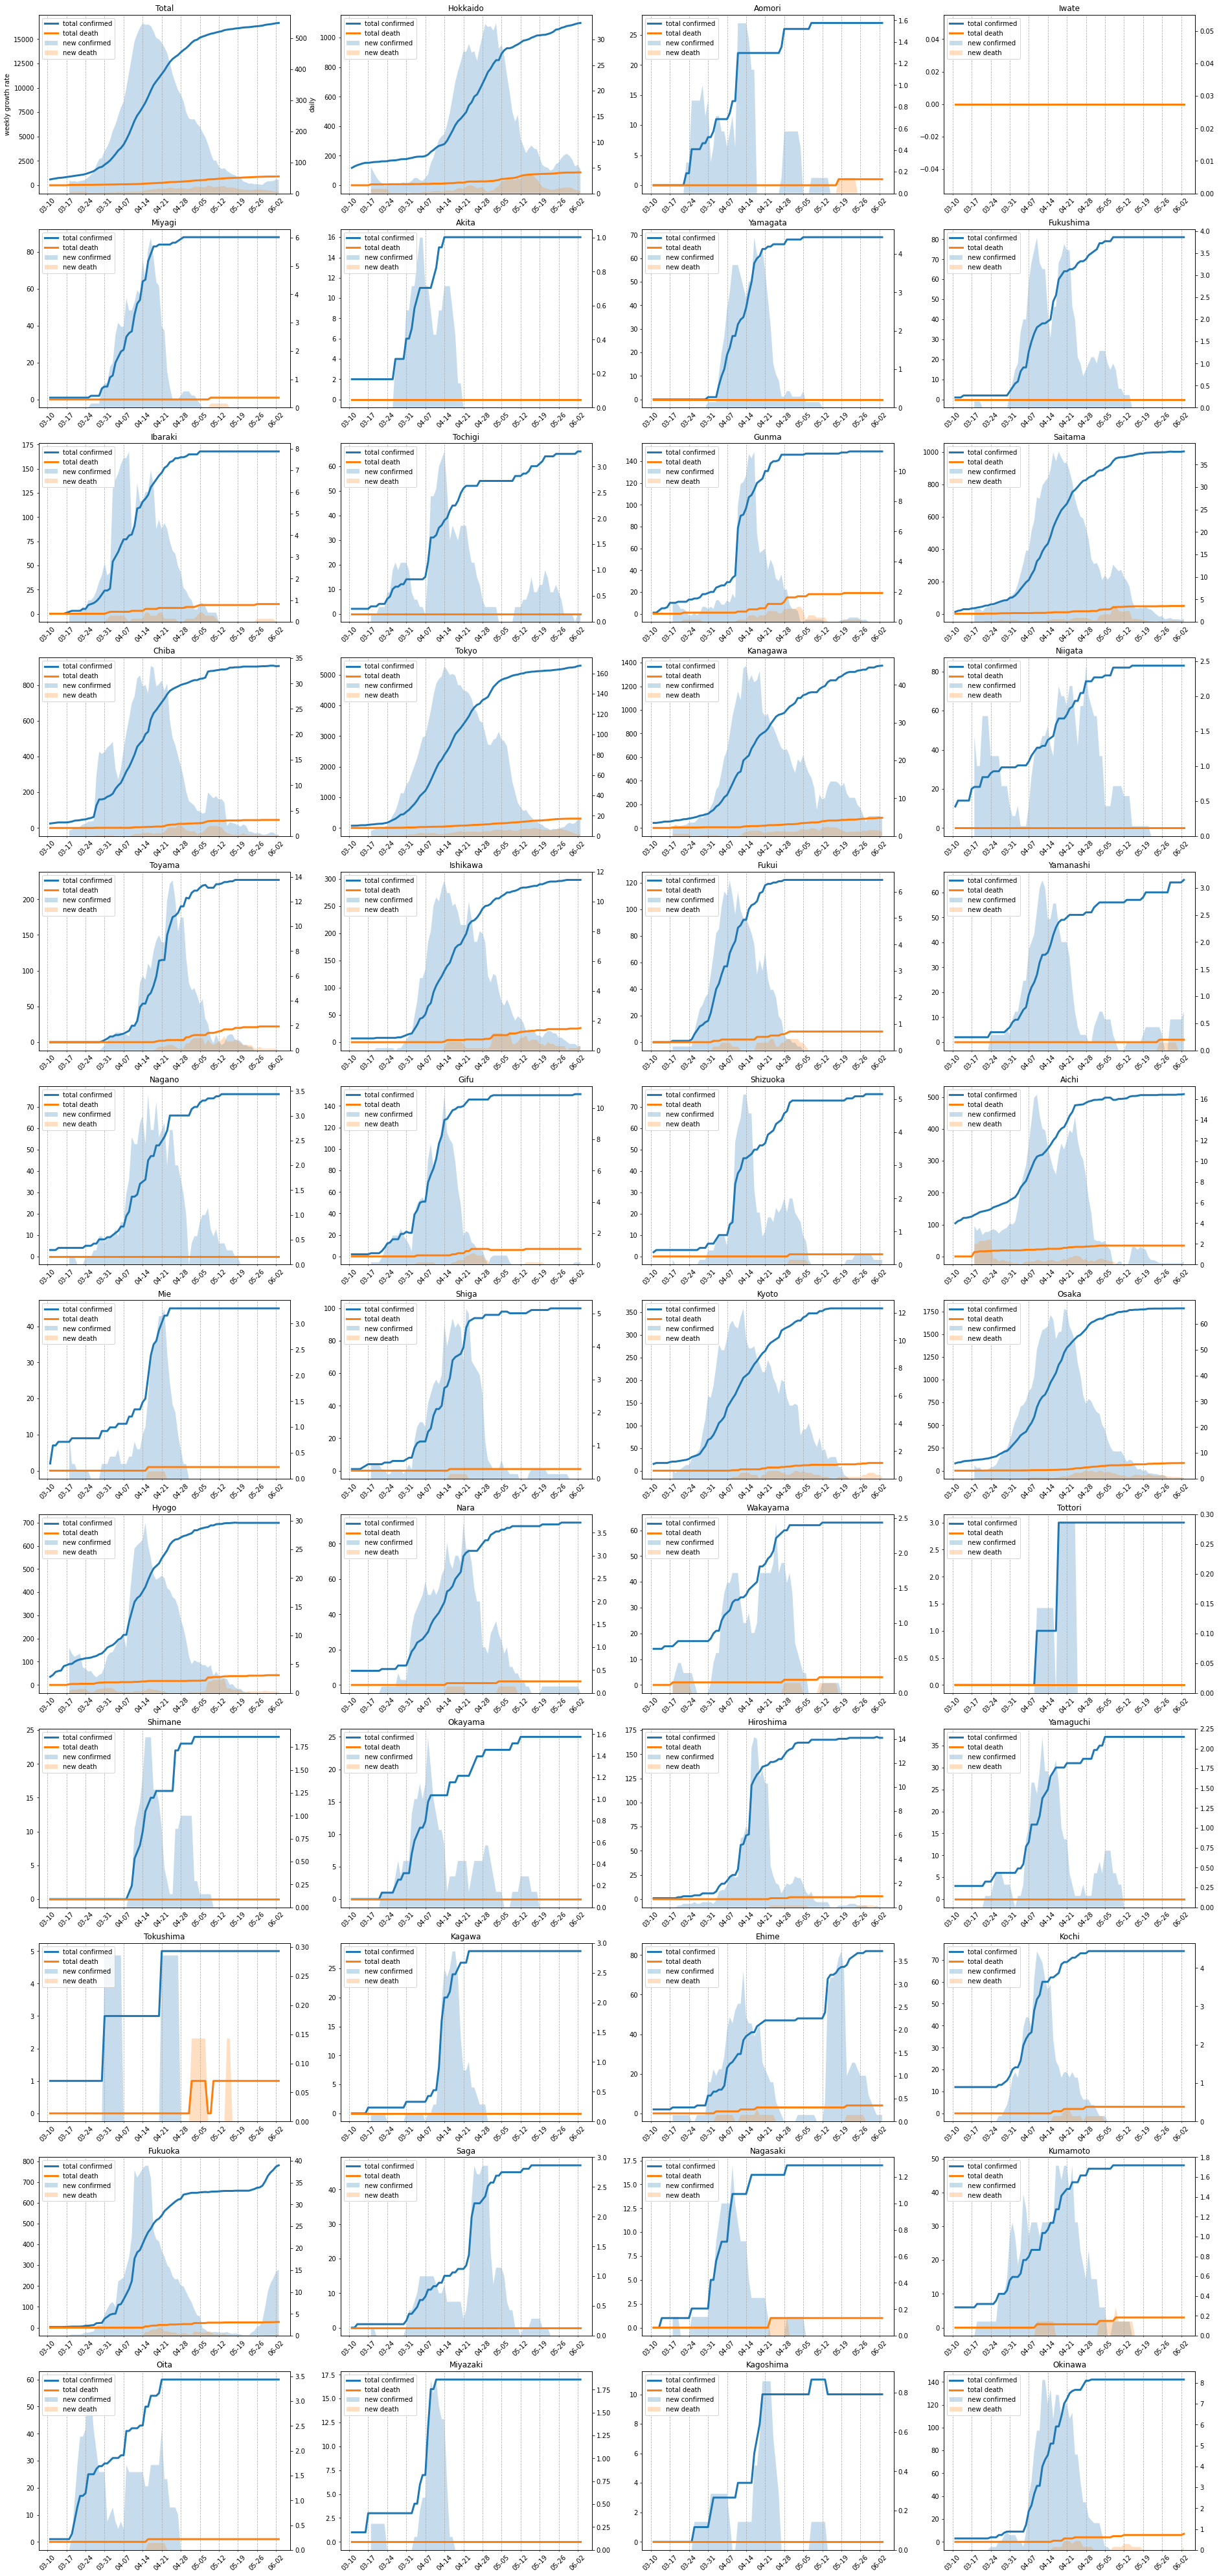

In [11]:

W = 7 # 移動平均を取る日数
cols = 4 # 1行に表示するタイルの数（列数）
rows = np.ceil(len(pref_set)/cols) # タイルの行数

fig = plt.figure( figsize=(8*cols, 6*rows) ) # タイル数に応じた大きさの figure オブジェクトを用意

for (pid, pref) in enumerate(pref_set): # enumerate を使うことで，県名 pref と同時に「何番目の図か」を表すインデックス pid を得ている
    # 県別データフレームを構成
    if pref == "全国": # 県名に"全国"が指定された場合は，各日について全県の和をとったものをデータフレームとする
        pref_df = jp_df.groupby(level=1).sum()
        pref_df["Pref"] = "Total"
    else:
        pref_df = jp_df.loc[pref] # 当該県データのみのデータフレームを構築

    # 陽性数と死亡数を取得
    conf = pref_df["陽性数"] # 陽性と確定した者(confirmed)
    dead = pref_df["死亡数"] # 死亡者(dead)
    
    # add_subplot を使って複数の図をタイル状に配置
    ax1 = fig.add_subplot(rows, cols, pid+1)

    # 第1軸に累積陽性数/死亡数をプロットする
    ax1.plot(conf, label="total confirmed", zorder=10, linewidth=3)
    ax1.plot(dead, label="total death", zorder=10, linewidth=3)
    ax1 = fancy_ax(ax1) # ｘ軸の見栄えを整える

    # 第2軸に日次新規件数をプロットする
    ax2 = plt.twinx(ax1) # 第2軸を用意する
    ax2.fill_between(conf.index, conf.diff().rolling(W).mean(), label="new confirmed", alpha=0.25, zorder=1) # 陽性者
    ax2.fill_between(dead.index, dead.diff().rolling(W).mean(), label="new death", alpha=0.25, zorder=1) # 死亡者
    ax2.set_yscale('linear') # y2軸を線形軸で表示
    ax2.set_ylim(0,) # y2軸の表示下限を0にする
    ax2.set_xticks([]) # x2軸は表示しない
    
    # 最初の図だけ y1/y2軸ラベルを付ける
    if pid == 0:
        ax1.set_ylabel("weekly growth rate") # y1軸ラベル
        ax2.set_ylabel("daily") # y2軸ラベル
        
    # y1軸をy2軸の上に表示させる
    ax1.set_zorder(ax2.get_zorder()+1)
    ax1.patch.set_visible(False)

    # グラフのタイトルと凡例を表示
    ax1.set_title(pref_df["Pref"][0]) # "Pref"列の第0要素（先頭要素）をタイトルとして表示
    h1, l1 = ax1.get_legend_handles_labels() # ax1軸の凡例を抽出するおまじない
    h2, l2 = ax2.get_legend_handles_labels() # ax2軸の凡例を抽出するおまじない
    ax1.legend(h1+h2, l1+l2, loc='upper left') # ax1軸とax2軸の凡例を一緒に出力するおまじない

plt.show()